## Step 3: Data Cleaning & EDA

### Data Dictionary
| Field       | Data Type | Description                                                                                         |
|-------------|-----------|-----------------------------------------------------------------------------------------------------|
| compound    | float     | overall score from VADER sentiment analysis                                                         |
| created_UTC | int       | time stamp of when the post was initially created on subreddit <br>used in data collection only |
| length      | int       | character count of the post after cleaning                                       |
| neg         | float     | score for negative-oriented sentiment                                                               |
| neu         | float     | score for neutral sentiment                                                                         |
| pos         | float     | score for positive-oriented sentiment                                                               |
| selftext    | str       | content of the post                                                                                 |
| subreddit   | int       | Anxiety = 0<br>ADHD = 1<br>Depression = 2<br>Autism = 3                                             |
| title       | str       | title of the post                                                                                   |
| word count  | int       | number of words in the post, after cleaning                                       |

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
anxiety = pd.read_csv('./anxiety.csv')
adhd = pd.read_csv('./adhd.csv')
autism = pd.read_csv('./autism.csv')
depression = pd.read_csv('./depression.csv')

### Cleaning

Immediately upon looking at the data, I could see that some posts had been flagged for deletion or removal by either subreddit mods or the original poster. There were also some posts that had no text content (presumably a picture). 

I wrote a function called `gone_posts` to convert all removed or deleted posts to nulls, then I deleted nulls. This left between 3600-4500 posts per subreddit. 

In [3]:
anxiety.head()

,subreddit,title,selftext,created_utc
0,Anxiety,"If you're looking for someone to talk to, I'm ...",\nAvailable most of the time. 24M.,1635429580
1,Anxiety,Weird Things that Give Me Anxiety,I have a lot of things that trigger my anxiety...,1635429095
2,Anxiety,Im supee anxious waiting for the company's fin...,I interviewed for a company and I really like ...,1635429059
3,Anxiety,Anxiety physical Symptoms,What kind of physical symptoms do you experien...,1635428166
4,Anxiety,Afraid that I’m going crazy,[removed],1635427998


In [4]:
adhd.head()

,subreddit,title,selftext,created_utc
0,ADHD,First time diagnosed adhd? Vyvanse 30mg.,Hey friends. 25m here. Ive been recently diagn...,1635429501
1,ADHD,What have been your experiences trying LSD/tru...,[removed],1635429424
2,ADHD,Strategies,Hey Everyone \n\nSo for the past few days I’ve...,1635429357
3,ADHD,"Started Straterra 5 days ago, already noticed ...",Like the title says. I finally bit the bullet ...,1635428794
4,ADHD,Effects of Adderall Make Me Think I Don't Actu...,So I've been taking Adderall for a little whil...,1635428534


In [5]:
autism.head()

,subreddit,title,selftext,created_utc
0,aspergers,What social thing was the hardest for you to u...,Personally I'm still figuring out that you're ...,1635429444
1,aspergers,Winnipeg man found with illegal firearms diagn...,"Judge gives man conditional sentence, says he'...",1635428083
2,aspergers,Typhon Mind - a new project of mine - a deep d...,[removed],1635427450
3,aspergers,How do i know if I'm autistic?,"\n\nHi, so let me start off by apologizing fo...",1635426591
4,aspergers,I applied to work at a small movie theater,The idea of jobs alone stress me out and I was...,1635424264


In [6]:
depression.head()

,subreddit,title,selftext,created_utc
0,depression,Should I stop medical school?,I have been having multiple episodes of mania ...,1635429540
1,depression,Being a gay teen,I don’t know where to start with this so I’ll ...,1635429342
2,depression,Here but should not be,I sometimes think that things are going wrong ...,1635429084
3,depression,I literally can't go on like this anymore,Most of the days are nothing but stress and o...,1635428969
4,depression,Hehe,Drinking helps pass time and (fortunately) giv...,1635428502


In [7]:
anxiety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2000 non-null   object
 1   title        2000 non-null   object
 2   selftext     1922 non-null   object
 3   created_utc  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


In [8]:
adhd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    1999 non-null   object
 1   title        1999 non-null   object
 2   selftext     1999 non-null   object
 3   created_utc  1999 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


In [9]:
autism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2000 non-null   object
 1   title        2000 non-null   object
 2   selftext     1909 non-null   object
 3   created_utc  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


In [10]:
depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2000 non-null   object
 1   title        2000 non-null   object
 2   selftext     1999 non-null   object
 3   created_utc  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


In [11]:
def gone_posts(x):
    if x == '[removed]':
        return np.nan
    elif x == '[deleted]':
        return np.nan
    else:
        return x

In [12]:
anxiety['selftext'] = anxiety['selftext'].map(gone_posts)
depression['selftext'] = depression['selftext'].map(gone_posts)
adhd['selftext'] = adhd['selftext'].map(gone_posts)
autism['selftext'] = autism['selftext'].map(gone_posts)

In [13]:
anxiety.dropna(inplace = True)
adhd.dropna(inplace = True)
autism.dropna(inplace = True)
depression.dropna(inplace = True)

In [14]:
anxiety.shape, adhd.shape, autism.shape, depression.shape

((1844, 4), (1509, 4), (1329, 4), (1663, 4))

I removed links and line breaks from the dataframes. Then I combined the title and selftext columns so there was only one column for text. 

In [15]:
anxiety['selftext'] = anxiety['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)
adhd['selftext'] = adhd['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)
autism['selftext'] = autism['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)
depression['selftext'] = depression['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)

In [16]:
anxiety['selftext'] = anxiety['selftext'] + anxiety['title']
anxiety.drop(columns = 'title', inplace = True)
adhd['selftext'] = adhd['selftext'] + adhd['title']
adhd.drop(columns = 'title', inplace = True)
autism['selftext'] = autism['selftext'] + autism['title']
autism.drop(columns = 'title', inplace = True)
depression['selftext'] = depression['selftext'] + depression['title']
depression.drop(columns = 'title', inplace = True)

## EDA

#### Post Length

I wanted to see how long the posts were and whether they varied between subreddits, so I created a column for `word count` and `length` (character count). There were some differences, but nothing that was particularly compelling. All the subreddits had a mean post length between 162-206 words. 

Looking at various plots of post length, all four subreddits had similar distributions, minimums and maximums. Therefore, I decided not to remove any outliers for length, with one exception: one of the posts from the ADHD subreddit was 36,598 characters. CSV files can accept a maximum of 32,767 per "cell," so I removed any posts longer than that. 

In [17]:
def word_count(post):
    return len(post.split())

In [18]:
anxiety['length'] = anxiety['selftext'].map(len)
anxiety['word_count'] = anxiety['selftext'].map(word_count)
autism['length'] = autism['selftext'].map(len)
autism['word_count'] = autism['selftext'].map(word_count)
adhd['length'] = adhd['selftext'].map(len)
adhd['word_count'] = adhd['selftext'].map(word_count)
depression['length'] = depression['selftext'].map(len)
depression['word_count'] = depression['selftext'].map(word_count)

In [19]:
anxiety.describe()

,created_utc,length,word_count
count,1.844000e+03,1844.000000,1844.000000
mean,1.635081e+09,858.508677,162.543384
std,2.011243e+05,827.896510,156.847583
min,1.634735e+09,28.000000,3.000000
25%,1.634905e+09,382.750000,71.000000
50%,1.635096e+09,649.500000,123.500000
75%,1.635260e+09,1055.000000,200.000000
max,1.635430e+09,11229.000000,2079.000000


In [20]:
adhd.describe()

,created_utc,length,word_count
count,1.509000e+03,1509.000000,1509.000000
mean,1.635259e+09,1128.386349,210.532140
std,9.696447e+04,1163.416165,217.676094
min,1.635088e+09,94.000000,14.000000
25%,1.635179e+09,547.000000,101.000000
50%,1.635263e+09,823.000000,154.000000
75%,1.635348e+09,1310.000000,247.000000
max,1.635430e+09,20149.000000,3669.000000


In [21]:
adhd = adhd[adhd['length'] < 32767]

In [22]:
adhd.describe()

,created_utc,length,word_count
count,1.509000e+03,1509.000000,1509.000000
mean,1.635259e+09,1128.386349,210.532140
std,9.696447e+04,1163.416165,217.676094
min,1.635088e+09,94.000000,14.000000
25%,1.635179e+09,547.000000,101.000000
50%,1.635263e+09,823.000000,154.000000
75%,1.635348e+09,1310.000000,247.000000
max,1.635430e+09,20149.000000,3669.000000


In [23]:
depression.describe()

,created_utc,length,word_count
count,1.663000e+03,1663.000000,1663.000000
mean,1.635265e+09,906.526759,174.432351
std,8.958431e+04,1090.379328,211.629581
min,1.635118e+09,35.000000,5.000000
25%,1.635191e+09,310.000000,60.000000
50%,1.635267e+09,597.000000,116.000000
75%,1.635343e+09,1114.500000,212.500000
max,1.635430e+09,21095.000000,4246.000000


In [24]:
autism.describe()

,created_utc,length,word_count
count,1.329000e+03,1329.000000,1329.000000
mean,1.634243e+09,935.828442,172.690745
std,6.898110e+05,1078.439534,197.586331
min,1.632804e+09,29.000000,4.000000
25%,1.633726e+09,334.000000,61.000000
50%,1.634267e+09,625.000000,114.000000
75%,1.634809e+09,1138.000000,211.000000
max,1.635429e+09,15993.000000,2890.000000


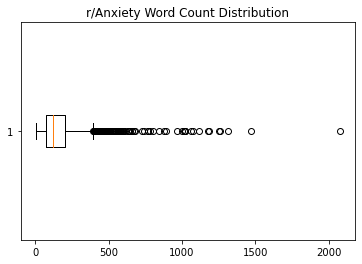

In [25]:
plt.boxplot(anxiety['word_count'], vert = False)
plt.title('r/Anxiety Word Count Distribution');

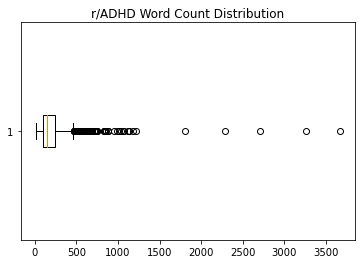

In [26]:
plt.boxplot(adhd['word_count'], vert = False)
plt.title('r/ADHD Word Count Distribution');

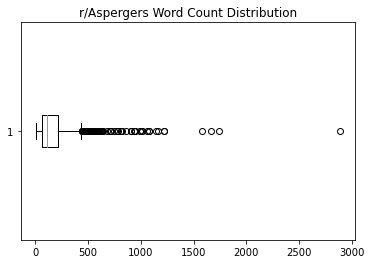

In [27]:
plt.boxplot(autism['word_count'], vert = False)
plt.title('r/Aspergers Word Count Distribution');

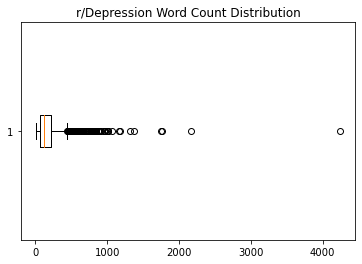

In [28]:
plt.boxplot(depression['word_count'], vert = False)
plt.title('r/Depression Word Count Distribution');

I combined all four subreddits into a single dataframe and reset the indices. The four groups in the target subreddit column are fairly even, but it will be worth stratifying when modeling. 

Then I looked at word count and character length overall, and the same patterns I had observed previously seemed to hold true.  

In [29]:
df = pd.concat(objs = [anxiety, adhd, depression, autism])
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html#pandas.DataFrame.reset_index

In [30]:
df.describe()

,created_utc,length,word_count
count,6.345000e+03,6345.000000,6345.000000
mean,1.634996e+09,951.472813,179.197794
std,5.214436e+05,1042.273494,196.582626
min,1.632804e+09,28.000000,3.000000
25%,1.634926e+09,397.000000,74.000000
50%,1.635185e+09,677.000000,127.000000
75%,1.635298e+09,1157.000000,219.000000
max,1.635430e+09,21095.000000,4246.000000


In [31]:
#Baseline
df['subreddit'].value_counts(normalize = True)

Anxiety       0.290623
depression    0.262096
ADHD          0.237825
aspergers     0.209456
Name: subreddit, dtype: float64

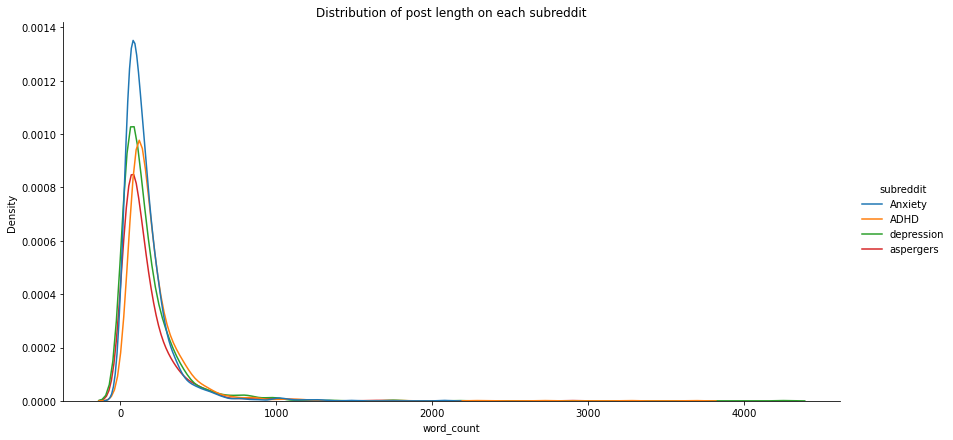

In [32]:
sns.displot(data = df, x = df['word_count'], hue = df['subreddit'], kind = 'kde',
           height = 6, aspect = 2)
plt.title('Distribution of post length on each subreddit');

#### Top Words

Using CountVectorizer, I took a look at the most common words in each subreddit and for the entire dataset. Based on these top word lists, I was satisfied that I had gotten the type of posts that I was looking for: posts about people's lives, wants, feelings, etc. 

I noticed a few other things that I made decisions about when it came to modeling:
- There are still some non-content words or partial words making it through the standard English stop words. I decided to add some custom stop words before modeling. 
- In some of the subreddits, the name of the condition is one of the most common words. "Anxiety" is in the top 10 overall. I thought about adding these terms to the stop words as well, but chose not to for a couple of reasons:
 - Some words, such as "anxious" and "depressed" are common words that every person might use to describe their mental state from time to time. 
 - Since the point of the models is to try to disentangle complicated interactions between different conditions, it would be more realistic to leave the names of conditions in the data. People might describe parts of their experience in one subreddit that would be equally at home in one of the other subreddits. 

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words = 'english')
cvecx = cvec.fit_transform(anxiety['selftext'])
cvecx_df = pd.DataFrame(cvecx.todense(), columns=cvec.get_feature_names())
cveca = cvec.fit_transform(adhd['selftext'])
cveca_df = pd.DataFrame(cveca.todense(), columns=cvec.get_feature_names())
cvecd = cvec.fit_transform(depression['selftext'])
cvecd_df = pd.DataFrame(cvecd.todense(), columns=cvec.get_feature_names())
cvect = cvec.fit_transform(autism['selftext'])
cvect_df = pd.DataFrame(cvect.todense(), columns=cvec.get_feature_names())
cvec_all = cvec.fit_transform(df['selftext'])
cvec_all_df = pd.DataFrame(cvec_all.todense(), columns=cvec.get_feature_names())

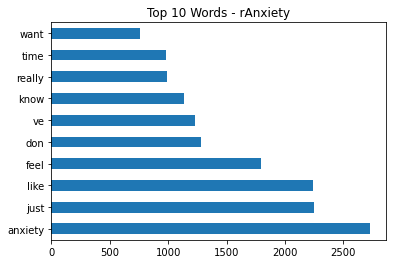

In [34]:
cvecx_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Top 10 Words - rAnxiety');

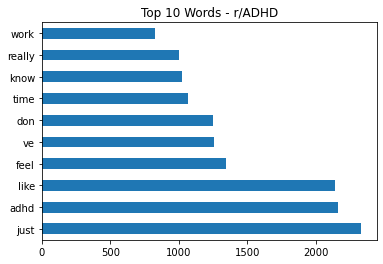

In [35]:
cveca_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Top 10 Words - r/ADHD');

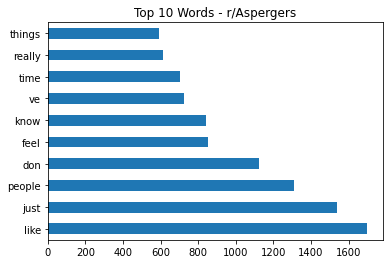

In [36]:
cvect_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Top 10 Words - r/Aspergers');

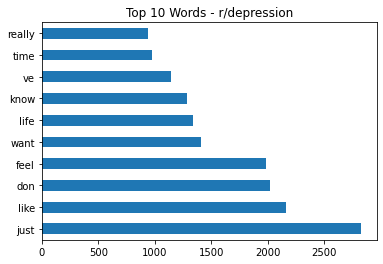

In [37]:
cvecd_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Top 10 Words - r/depression');

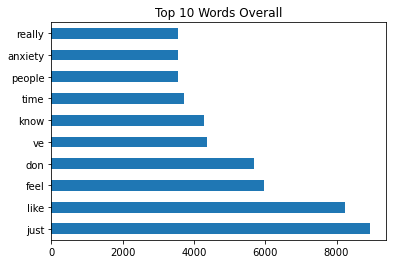

In [38]:
cvec_all_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Top 10 Words Overall');

#### Sentiment Analysis

Given the topic, emotional inflection of a post is extremely relevant to this dataset. I did a basic sentiment analysis and looked at each subreddit as well as the overall data. 

A couple of trends worth noting:
- The anxiety and depression subreddits are much more negative than the ADHD and autism subreddits. 
- The neutral and positive mean scores are relatively close across the subreddits, but the range of positive scores is quite a bit lower for the ADHD posts. This suggests that the ADHD community may be less focused on emotions than the other communities. 


In [39]:
corpus = list(df['selftext'])
sia = SentimentIntensityAnalyzer()

sentiments = []

for post in corpus:
    scores = sia.polarity_scores(post)
    scores['selftext'] = post
    sentiments.append(scores)
    

In [40]:
sia_df = pd.DataFrame(sentiments)
sia_df['subreddit'] = df['subreddit']

df['compound'] = sia_df['compound']

In [41]:
sia_df.head()

,neg,neu,pos,compound,selftext,subreddit
0,0.000,0.864,0.136,0.4588,Available most of the time. 24M.If you're look...,Anxiety
1,0.133,0.819,0.048,-0.9260,I have a lot of things that trigger my anxiety...,Anxiety
2,0.051,0.800,0.149,0.9110,I interviewed for a company and I really like ...,Anxiety
3,0.118,0.815,0.067,-0.9755,What kind of physical symptoms do you experien...,Anxiety
4,0.147,0.736,0.117,-0.4125,"Anxiety, it doesn’t matter what you do, I’m no...",Anxiety


In [42]:
sia_df.groupby('subreddit')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
ADHD,1509.0,0.074265,0.789992,-0.9988,-0.81480,0.2942,0.879300,0.9994
Anxiety,1844.0,-0.343511,0.726570,-0.9994,-0.94855,-0.7358,0.316275,0.9981
aspergers,1329.0,0.091320,0.762359,-0.9999,-0.74690,0.2418,0.863600,0.9997
depression,1663.0,-0.310435,0.742691,-0.9996,-0.95490,-0.7071,0.401900,0.9993


In [43]:
sia_df.groupby('subreddit')['neg'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
ADHD,1509.0,0.094359,0.056346,0.0,0.05400,0.088,0.13100,0.335
Anxiety,1844.0,0.158286,0.078900,0.0,0.10575,0.153,0.20225,0.575
aspergers,1329.0,0.097469,0.071838,0.0,0.04400,0.090,0.14300,0.488
depression,1663.0,0.175554,0.088048,0.0,0.11900,0.168,0.22400,0.592


In [44]:
sia_df.groupby('subreddit')['neu'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
ADHD,1509.0,0.798784,0.072578,0.575,0.7510,0.802,0.849,1.0
Anxiety,1844.0,0.740241,0.088090,0.226,0.6870,0.745,0.797,1.0
aspergers,1329.0,0.788051,0.092463,0.407,0.7320,0.788,0.848,1.0
depression,1663.0,0.700867,0.096319,0.329,0.6445,0.703,0.762,1.0


In [45]:
sia_df.groupby('subreddit')['pos'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
ADHD,1509.0,0.106866,0.055455,0.0,0.07000,0.103,0.13900,0.350
Anxiety,1844.0,0.101482,0.065447,0.0,0.05775,0.095,0.13525,0.774
aspergers,1329.0,0.114477,0.078816,0.0,0.06500,0.106,0.15000,0.593
depression,1663.0,0.123560,0.072692,0.0,0.07400,0.118,0.16650,0.520


### Tidying up

Before exporting my final dataframes, I decided to convert my target columns to numeric values and dropped the `length` feature, as it is correlated with `word_count`. Then I double-checked my baseline. 

In [46]:
df['subreddit'] = df['subreddit'].map({'Anxiety': 0, 'ADHD': 1,'depression': 2, 'aspergers' : 3})

In [49]:
df.drop(columns = 'length', inplace = True)

In [47]:
df['subreddit'].value_counts(normalize = True)

0    0.290623
2    0.262096
1    0.237825
3    0.209456
Name: subreddit, dtype: float64

In [48]:
df.to_csv('df.csv', index = False)
sia_df.to_csv('sentiment.csv', index = False)
anxiety.to_csv('anxiety.csv', index = False)
adhd.to_csv('adhd.csv', index = False)
depression.to_csv('depression.csv', index = False)
autism.to_csv('autism.csv', index = False)